## Analysis of latency for BlueStore (4k 30s randwrite)

In this experiment, I set the `bluestore_min_alloc_size` to `4096`, so most of the writes should goes to `do_write_big`, rather than `do_write_small`. So the deferred writes is limited(`<1%`).

We set the osd op_queue shard number to 4

bluestore_lat with deferred_writes over 5000 datapoints= 0.00721938518000002 s
bluestore_lat with deferred_writes of all datapoints= 0.010063254139699815 s


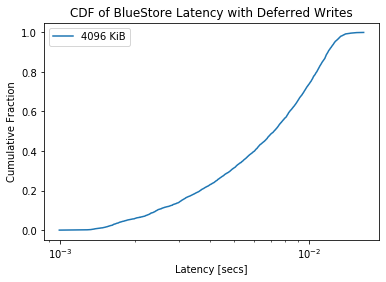

bluestore_lat with simple_writes over 10000 datapoints= 0.001709254516699997 s
bluestore_lat with simple_writes of all datapoints= 0.002049904982301304 s


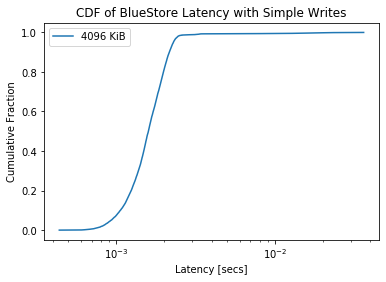

bluestore_lat over 10000 datapoints= 0.0019618537019000055 s
bluestore_lat of all datapoints= 0.002210744532195879 s


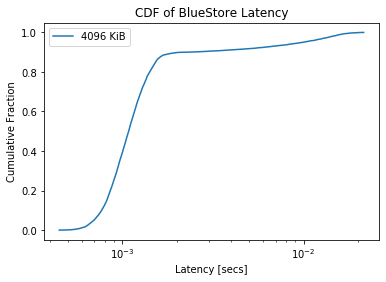

Average Workload Latency = 0.003481479593216 s
Average Throughput = 53.78029823303223 MB/s


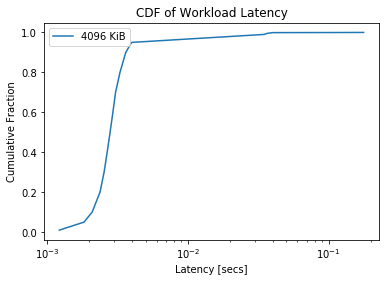

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from pandas import read_csv
import pandas as pd
import json

# figure 1: only plot deferred writes
x1 = []
y1 = []
f1='dump_bluestore_deferred_writes_lat_vec-48.csv'
data1=read_csv(f1, header=0, skiprows=1000, nrows=5000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_bs_lat_all = sum(alldata1) / len(alldata1)
print("bluestore_lat with deferred_writes over 5000 datapoints=",avg_bs_lat_partial,"s")
print("bluestore_lat with deferred_writes of all datapoints=",avg_bs_lat_all,"s")
for i in range(0, 5000, 2):
    x1.append(data1[int(i/5000. * len(data1))])
    y1.append(i/5000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Latency with Deferred Writes')
plt.legend()
plt.show()
plt.close()

# figure 1: only plot simple writes
x1 = []
y1 = []
f1='dump_bluestore_simple_writes_lat_vec-48.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_bs_lat_all = sum(alldata1) / len(alldata1)
print("bluestore_lat with simple_writes over 10000 datapoints=",avg_bs_lat_partial,"s")
print("bluestore_lat with simple_writes of all datapoints=",avg_bs_lat_all,"s")
for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Latency with Simple Writes')
plt.legend()
plt.show()
plt.close()

# figure 3: plot all bluestore latency
# aio_lat + kv_lat
x1 = []
y1 = []
f1='dump_bluestore_lat_vec-48.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
alldata1 = read_csv(f1, header=0, parse_dates=True, squeeze=True)
avg_bs_lat_all = sum(alldata1) / len(alldata1)
print("bluestore_lat over 10000 datapoints=",avg_bs_lat_partial,"s")
print("bluestore_lat of all datapoints=",avg_bs_lat_all,"s")
for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of BlueStore Latency')
plt.legend()
plt.show()
plt.close()

# workload latency
with open('dump-fio-bench-48.json') as f:
  data2 = json.load(f)
avg_lat = data2['jobs'][0]['write']['clat_ns']['mean']/1000000000
avg_throughput = data2['jobs'][0]['write']['bw_bytes']/1048576
print("Average Workload Latency =",avg_lat,"s")
print("Average Throughput =",avg_throughput,"MB/s")
x2 = []
y2 = []
for key, value in data2['jobs'][0]['write']['clat_ns']['percentile'].items():
    x2.append(value/1000000000)
    y2.append(float(key)/100)
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.plot(x2, y2, label='4096 KiB')
ax.set(xlabel='Latency [secs]', ylabel='Cumulative Fraction', title='CDF of Workload Latency')
plt.legend()
plt.show()
plt.close()


Next, we try to observe the bluestore kv_queue size:

average kv_queue size = 16.6882


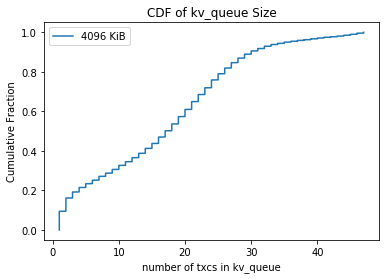

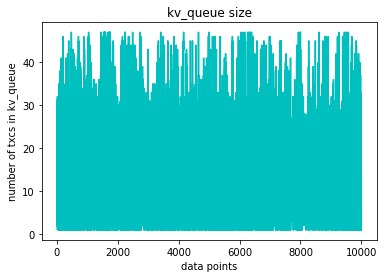

In [2]:
x1 = []
y1 = []
f1='dump_kv_queue_size_vec-48.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
print("average kv_queue size =",avg_bs_lat_partial)

for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)

fig, ax = plt.subplots()
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='number of txcs in kv_queue', ylabel='Cumulative Fraction', title='CDF of kv_queue Size')
plt.legend()
plt.show()
plt.close()

data2=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True)
fig, ax = plt.subplots()
data2.plot(style='c-', label='kv_queue_size')
ax.set(xlabel='data points', ylabel='number of txcs in kv_queue', title='kv_queue size') 
plt.show()
plt.close()    

Next, we try to observe the OSD sharded op_queue size:

average op_queue size = 13.0916


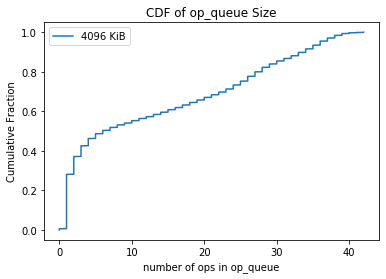

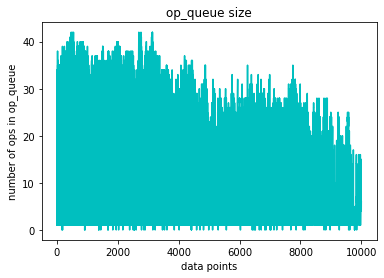

In [3]:
x1 = []
y1 = []
f1='dump_opq_size_vec-48.csv'
data1=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True).sort_values(ignore_index=True)
avg_bs_lat_partial = sum(data1) / len(data1)
print("average op_queue size =",avg_bs_lat_partial)

for i in range(0, 10000, 2):
    x1.append(data1[int(i/10000. * len(data1))])
    y1.append(i/10000.)

fig, ax = plt.subplots()
ax.plot(x1, y1, label='4096 KiB')
ax.set(xlabel='number of ops in op_queue', ylabel='Cumulative Fraction', title='CDF of op_queue Size')
plt.legend()
plt.show()
plt.close()

data2=read_csv(f1, header=0, skiprows=20000, nrows=10000, parse_dates=True, squeeze=True)
fig, ax = plt.subplots()
data2.plot(style='c-', label='4096 KiB')
ax.set(xlabel='data points', ylabel='number of ops in op_queue', title='op_queue size') 
plt.show()
plt.close()    